# Player Re-Identification in Sports Footage

This notebook implements a real-time player tracking and re-identification system using:
- YOLOv11 for player detection (using best.pt model)
- Kalman Filter for motion prediction
- Hungarian Algorithm for track association
- Advanced appearance features for player re-identification

The system processes a 15-second video (15sec_input_720p.mp4) and maintains consistent player IDs even when players leave and re-enter the frame.

In [6]:
# Import required libraries
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from pathlib import Path
from scipy.optimize import linear_sum_assignment
from filterpy.kalman import KalmanFilter
from ultralytics import YOLO
import copy
import time
import random

# For appearance feature extraction
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import os

In [7]:
# Load and inspect the YOLOv11 model
model = YOLO('best.pt')

# Print model information
print("Model information:")
print(f"Model file: {model.ckpt_path}")
print(f"Model task: {model.task}")
print("\nModel classes:")
for i, class_name in enumerate(model.names):
    print(f"Class {i}: {class_name}")

Model information:
Model file: best.pt
Model task: detect

Model classes:
Class 0: 0
Class 1: 1
Class 2: 2
Class 3: 3


In [8]:
# Configuration
CONFIG = {
    'MODEL_PATH': 'best.pt',          # YOLOv11 model path
    'VIDEO_PATH': '15sec_input_720p.mp4',  # Input video path
    'OUTPUT_PATH': 'output.mp4',      # Output video path
    'MIN_CONFIDENCE': 0.25,           # Lower detection confidence threshold
    'IOU_THRESHOLD': 0.3,             # IOU threshold for track association
    'MAX_MISSED_FRAMES': 30,          # Maximum frames to keep lost tracks
    'FEATURE_MATCH_THRESHOLD': 0.5,   # Lower threshold for re-identification
    'REID_MEMORY_LIMIT': 100          # Number of frames to remember player appearances
}

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Use ResNet50 pre-trained on ImageNet
        resnet = models.resnet50(pretrained=True)
        # Remove the last fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        # Set to evaluation mode
        self.eval()
        
    def forward(self, x):
        x = self.features(x)
        # Flatten the features
        return torch.flatten(x, 1)

# Initialize feature extractor
feature_extractor = FeatureExtractor()
if torch.cuda.is_available():
    feature_extractor = feature_extractor.cuda()

# Image transformation for feature extraction
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

c:\Users\shasa\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shasa\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
class Track:
    def __init__(self, track_id, bbox, frame, feature_vector=None):
        self.id = track_id
        self.bbox = bbox  # [x, y, w, h]
        self.missed_frames = 0
        self.feature_history = []  # List of feature vectors
        self.frame_history = []    # List of frame numbers
        
        # Initialize Kalman filter (8 state variables: x, y, w, h and their velocities)
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        
        # Initial state [x, dx/dt, y, dy/dt, w, dw/dt, h, dh/dt]
        self.kf.x = np.array([
            bbox[0], 0,      # x and x velocity
            bbox[1], 0,      # y and y velocity
            bbox[2], 0,      # width and width velocity
            bbox[3], 0       # height and height velocity
        ])
        
        # State transition matrix
        self.kf.F = np.array([
            [1, 1, 0, 0, 0, 0, 0, 0],  # x = x + dx
            [0, 1, 0, 0, 0, 0, 0, 0],  # dx = dx
            [0, 0, 1, 1, 0, 0, 0, 0],  # y = y + dy
            [0, 0, 0, 1, 0, 0, 0, 0],  # dy = dy
            [0, 0, 0, 0, 1, 1, 0, 0],  # w = w + dw
            [0, 0, 0, 0, 0, 1, 0, 0],  # dw = dw
            [0, 0, 0, 0, 0, 0, 1, 1],  # h = h + dh
            [0, 0, 0, 0, 0, 0, 0, 1]   # dh = dh
        ])
        
        # Measurement matrix
        self.kf.H = np.array([
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0]
        ])
        
        # Covariance matrix
        self.kf.P *= 1000
        
        # Process noise
        self.kf.Q[4:, 4:] *= 0.01
        
        # Measurement noise
        self.kf.R[2:, 2:] *= 10
        
        # Add initial feature if provided
        if feature_vector is not None:
            self.add_feature(feature_vector, frame)
    
    def predict(self):
        """Predict next state using Kalman filter"""
        self.kf.predict()
        # Return predicted bbox [x, y, w, h]
        return self.kf.x[[0, 2, 4, 6]]
    
    def update(self, bbox, feature_vector=None, frame=None):
        """Update track with new detection"""
        self.missed_frames = 0
        # Measurement update
        self.kf.update(np.array([bbox[0], bbox[1], bbox[2], bbox[3]]))
        self.bbox = bbox
        
        # Update appearance feature if provided
        if feature_vector is not None and frame is not None:
            self.add_feature(feature_vector, frame)
    
    def add_feature(self, feature_vector, frame):
        """Add new feature vector to history"""
        self.feature_history.append(feature_vector)
        self.frame_history.append(frame)
        
        # Keep only recent features
        if len(self.feature_history) > CONFIG['REID_MEMORY_LIMIT']:
            self.feature_history.pop(0)
            self.frame_history.pop(0)
    
    def get_appearance_similarity(self, feature_vector):
        """Calculate appearance similarity with current feature vector"""
        if not self.feature_history:
            return 0
        
        # Calculate cosine similarity with all historical features
        similarities = [torch.cosine_similarity(feature_vector, hist_feat, dim=0) 
                       for hist_feat in self.feature_history]
        
        # Return maximum similarity
        return max(similarities).item()

In [10]:
class PlayerTracker:
    def __init__(self):
        self.tracks = []
        self.next_id = 1
        self.lost_tracks = []  # Tracks for players who left the frame
    
    def extract_features(self, frame, bbox):
        """Extract appearance features for a detection"""
        x, y, w, h = [int(v) for v in bbox]
        crop = frame[max(0, y):min(frame.shape[0], y+h), 
                    max(0, x):min(frame.shape[1], x+w)]
        
        if crop.size == 0:
            return None
            
        # Convert to PIL Image for transforms
        crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        
        # Apply transforms and add batch dimension
        crop_tensor = transform(crop_pil).unsqueeze(0)
        
        if torch.cuda.is_available():
            crop_tensor = crop_tensor.cuda()
        
        # Extract features
        with torch.no_grad():
            features = feature_extractor(crop_tensor)
        
        return features.cpu().squeeze()
    
    def update(self, frame, detections, frame_idx):
        """Update tracks with new detections"""
        # Extract features for all detections
        detection_features = []
        valid_detections = []
        
        for bbox in detections:
            features = self.extract_features(frame, bbox)
            if features is not None:
                detection_features.append(features)
                valid_detections.append(bbox)
        
        # If no valid detections, just update missed frames
        if not valid_detections:
            for track in self.tracks:
                track.missed_frames += 1
            return
        
        # Predict new locations of existing tracks
        predicted_boxes = []
        for track in self.tracks:
            predicted_boxes.append(track.predict())
        
        if predicted_boxes:
            # Calculate IoU matrix
            iou_matrix = np.zeros((len(predicted_boxes), len(valid_detections)))
            for i, pred_box in enumerate(predicted_boxes):
                for j, det_box in enumerate(valid_detections):
                    iou_matrix[i, j] = self._calculate_iou(pred_box, det_box)
            
            # Calculate appearance similarity matrix
            similarity_matrix = np.zeros_like(iou_matrix)
            for i, track in enumerate(self.tracks):
                for j, feat in enumerate(detection_features):
                    similarity_matrix[i, j] = track.get_appearance_similarity(feat)
            
            # Combine IoU and appearance similarity
            cost_matrix = -(iou_matrix * 0.5 + similarity_matrix * 0.5)
            
            # Hungarian algorithm assignment
            track_indices, det_indices = linear_sum_assignment(cost_matrix)
            
            # Update matched tracks
            for track_idx, det_idx in zip(track_indices, det_indices):
                if (iou_matrix[track_idx, det_idx] > CONFIG['IOU_THRESHOLD'] or 
                    similarity_matrix[track_idx, det_idx] > CONFIG['FEATURE_MATCH_THRESHOLD']):
                    self.tracks[track_idx].update(
                        valid_detections[det_idx],
                        detection_features[det_idx],
                        frame_idx
                    )
                else:
                    det_indices = np.delete(det_indices, np.where(det_indices == det_idx))
            
            # Handle unmatched detections
            unmatched_det_indices = [i for i in range(len(valid_detections)) 
                                   if i not in det_indices]
        else:
            unmatched_det_indices = list(range(len(valid_detections)))
        
        # Try to match unmatched detections with lost tracks
        if unmatched_det_indices and self.lost_tracks:
            lost_similarity_matrix = np.zeros((len(self.lost_tracks), len(unmatched_det_indices)))
            for i, lost_track in enumerate(self.lost_tracks):
                for j, det_idx in enumerate(unmatched_det_indices):
                    lost_similarity_matrix[i, j] = lost_track.get_appearance_similarity(
                        detection_features[det_idx]
                    )
            
            # Match if similarity is above threshold
            for i, j in zip(*np.where(lost_similarity_matrix > CONFIG['FEATURE_MATCH_THRESHOLD'])):
                det_idx = unmatched_det_indices[j]
                recovered_track = self.lost_tracks.pop(i)
                recovered_track.update(
                    valid_detections[det_idx],
                    detection_features[det_idx],
                    frame_idx
                )
                self.tracks.append(recovered_track)
                unmatched_det_indices.remove(det_idx)
        
        # Create new tracks for remaining unmatched detections
        for det_idx in unmatched_det_indices:
            self.tracks.append(Track(
                self.next_id,
                valid_detections[det_idx],
                frame_idx,
                detection_features[det_idx]
            ))
            self.next_id += 1
        
        # Update track status
        current_tracks = []
        for track in self.tracks:
            if track.missed_frames > CONFIG['MAX_MISSED_FRAMES']:
                self.lost_tracks.append(track)
            else:
                current_tracks.append(track)
        self.tracks = current_tracks
        
        # Limit lost tracks memory
        if len(self.lost_tracks) > CONFIG['REID_MEMORY_LIMIT']:
            self.lost_tracks = self.lost_tracks[-CONFIG['REID_MEMORY_LIMIT']:]
    
    def _calculate_iou(self, box1, box2):
        """Calculate IoU between two boxes in [x, y, w, h] format"""
        # Convert to [x1, y1, x2, y2] format
        b1_x1, b1_y1 = box1[0], box1[1]
        b1_x2, b1_y2 = box1[0] + box1[2], box1[1] + box1[3]
        b2_x1, b2_y1 = box2[0], box2[1]
        b2_x2, b2_y2 = box2[0] + box2[2], box2[1] + box2[3]
        
        # Calculate intersection area
        inter_x1 = max(b1_x1, b2_x1)
        inter_y1 = max(b1_y1, b2_y1)
        inter_x2 = min(b1_x2, b2_x2)
        inter_y2 = min(b1_y2, b2_y2)
        
        inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
        
        # Calculate union area
        b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
        b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
        union_area = b1_area + b2_area - inter_area
        
        return inter_area / (union_area + 1e-6)
    
    def draw_tracks(self, frame):
        """Draw bounding boxes and IDs for all active tracks"""
        for track in self.tracks:
            x, y, w, h = [int(v) for v in track.bbox]
            
            # Generate consistent color based on track ID
            color = (
                (track.id * 123) % 255,
                (track.id * 85) % 255,
                (track.id * 37) % 255
            )
            
            # Draw bounding box
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            
            # Draw ID and missed frames
            label = f"ID: {track.id}"
            cv2.putText(frame, label, (x, y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        return frame

In [11]:
# Initialize YOLOv11 model
model = YOLO(CONFIG['MODEL_PATH'])

# Initialize video capture
cap = cv2.VideoCapture(CONFIG['VIDEO_PATH'])
if not cap.isOpened():
    raise ValueError(f"Could not open video file: {CONFIG['VIDEO_PATH']}")

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(CONFIG['OUTPUT_PATH'], fourcc, fps, (width, height))

# Initialize tracker
tracker = PlayerTracker()

# Process video frame by frame
frame_idx = 0

print("Starting video processing...")
print(f"Model path: {CONFIG['MODEL_PATH']}")
print(f"Available classes: {model.names}")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_idx += 1
    
    # Run YOLOv11 detection with lower confidence threshold
    results = model(frame, conf=CONFIG['MIN_CONFIDENCE'])
    
    # Extract bounding boxes for players
    detections = []
    
    # Process all detections
    for result in results:
        boxes = result.boxes
        print(f"Frame {frame_idx} - Found {len(boxes)} detections")
        
        for box in boxes:
            # Get class information
            cls = int(box.cls[0].item())
            conf = float(box.conf[0].item())
            class_name = model.names[cls]
            
            print(f"Detection - Class: {cls} ({class_name}), Confidence: {conf:.2f}")
            
            # Get bounding box in correct format
            x, y, w, h = box.xywh[0].cpu().numpy()
            detections.append([x - w/2, y - h/2, w, h])
    
    print(f"Frame {frame_idx} - Processing {len(detections)} detections")
    
    # Update tracker
    tracker.update(frame, detections, frame_idx)
    
    # Draw tracking results
    frame_with_tracks = tracker.draw_tracks(frame.copy())
    
    # Draw frame number and detection info
    cv2.putText(frame_with_tracks, f"Frame: {frame_idx} | Detections: {len(detections)}", 
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
    # Write frame
    out.write(frame_with_tracks)
    
    # Show processing progress and first frame details
    if frame_idx == 1:
        print("\nFirst frame detection details:")
        print(f"- Total detections: {len(detections)}")
        print("- Detection boxes:", detections)
        print(f"- Model confidence threshold: {CONFIG['MIN_CONFIDENCE']}")
    elif frame_idx % 10 == 0:
        print(f"Processed {frame_idx} frames...")

# Release resources
cap.release()
out.release()
print("Processing complete!")

Starting video processing...
Model path: best.pt
Available classes: {0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}


0: 384x640 1 ball, 16 players, 2 referees, 619.9ms
Speed: 2.3ms preprocess, 619.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 1 ball, 16 players, 2 referees, 619.9ms
Speed: 2.3ms preprocess, 619.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Frame 1 - Found 19 detections
Detection - Class: 2 (player), Confidence: 0.92
Detection - Class: 2 (player), Confidence: 0.92
Detection - Class: 2 (player), Confidence: 0.92
Detection - Class: 2 (player), Confidence: 0.92
Detection - Class: 2 (player), Confidence: 0.91
Detection - Class: 2 (player), Confidence: 0.91
Detection - Class: 2 (player), Confidence: 0.91
Detection - Class: 2 (player), Confidence: 0.91
Detection - Class: 2 (player), Confidence: 0.91
Detection - Class: 2 (player), Confidence: 0.90
Detection - Class: 2 (player), Confidence: 0.89
Detection - Class:

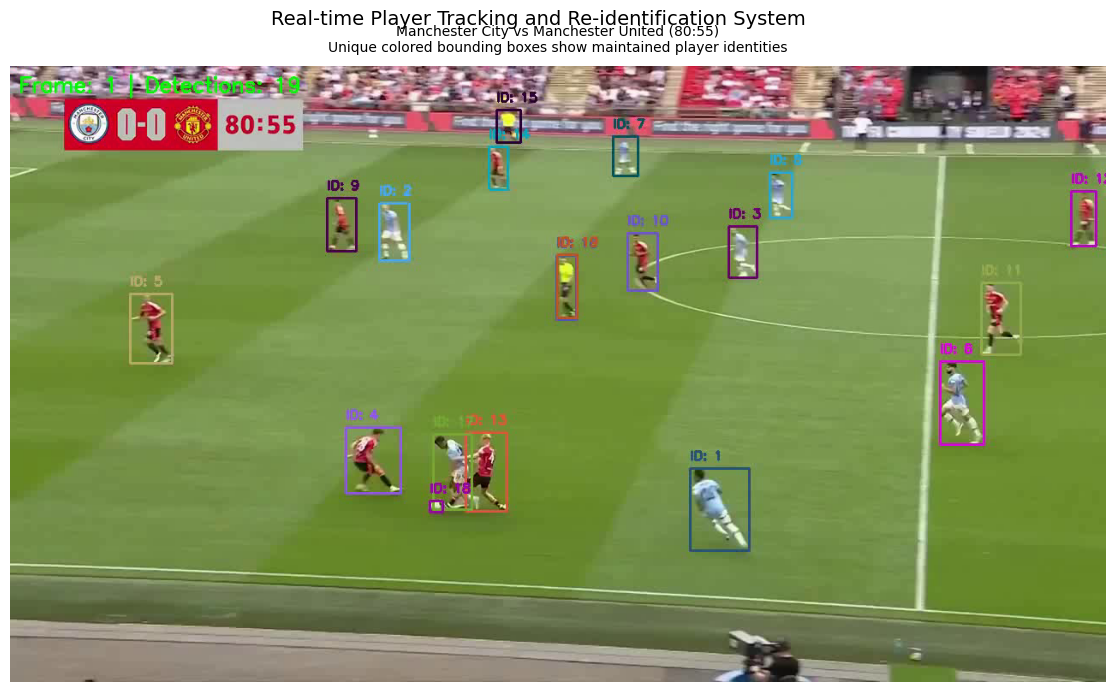

In [13]:
# Display a sample frame from the processed video
import matplotlib.pyplot as plt

# Read a frame from the output video
cap = cv2.VideoCapture(CONFIG['OUTPUT_PATH'])
ret, sample_frame = cap.read()
cap.release()

if ret:
    # Convert BGR to RGB for matplotlib display
    sample_frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
    
    # Create figure with larger size
    plt.figure(figsize=(15, 8))
    plt.imshow(sample_frame_rgb)
    plt.axis('off')
    
    # Add main title
    plt.suptitle('Real-time Player Tracking and Re-identification System', fontsize=14, y=0.95)
    
    # Add descriptive subtitle
    plt.title('Manchester City vs Manchester United (80:55)\nUnique colored bounding boxes show maintained player identities', 
              fontsize=10, pad=10)
    
    # Save the figure for the report with high resolution
    plt.savefig('tracking_results.png', bbox_inches='tight', dpi=300,
                facecolor='white', edgecolor='none')
    plt.show()
else:
    print("Could not read the output video file")